In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Data Cleaning & Pre- Processing

### 1. Import Data

In [2]:
Creditcard_data = pd.read_csv("C:/Users/pooja/Pooja Ingale/Projects/Time Series/Credit_card_transaction/creditcard.csv")

print(Creditcard_data.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

### 2. Handle Missing Values

In [3]:
# Check for missing values
# Check for missing values in each column
missing_values = Creditcard_data.isnull().sum()

# Print columns with missing values
print("Missing values in each column:")
print(missing_values[missing_values > 0])


Missing values in each column:
Series([], dtype: int64)


#### No missing values in dataset, hence no cleaning is needed.

### 3. Convert "Time" to actual datetime format.

In [4]:
# Converting the numeric value in "Time" column into a duration(timedelta object)
Creditcard_data['Time'] = pd.to_timedelta(Creditcard_data['Time'], unit='s')

# Creating a timestamp, using any fixed date and add duration from time column.
Creditcard_data['Date'] = pd.to_datetime('2025-01-01') + Creditcard_data['Time']

# Rounding down each timestamp to nearest hour.
Creditcard_data['Date'] = Creditcard_data['Date'].dt.floor('H')  


Note : 
1. The Time column only records the number of seconds elapsed since the first transaction, not actual calendar timestamps. Since we need a datetime index for time series models like Prophet or ARIMA, we arbitrarily assign a starting date just to convert the Time column into a real datetime format.

2. Rounding down timestamp to nearest hour for time based grouping. If we want to do group for day use .dt.floor('D') daily 

### 4. Grouping by time unit (hourly)

In [5]:
# grouping data by hour, aggregating grouped data and give new names.
txn_volume = Creditcard_data.groupby('Date').agg(
    total_txns=('Amount', 'count'),                  #counting total number of txns using “amount” column in that hour.
    total_amount=('Amount', 'sum'),                  #adding all the amount in that hour.
    fraud_count=('Class', 'sum')                     #total fraud in that hour.
).reset_index()                                      #Grouped Index(Date) as regular column.


In [6]:
print(txn_volume.head())

                 Date  total_txns  total_amount  fraud_count
0 2025-01-01 00:00:00        3963     257101.87            2
1 2025-01-01 01:00:00        2217     146105.69            2
2 2025-01-01 02:00:00        1576     108819.17           21
3 2025-01-01 03:00:00        1821      94306.84           13
4 2025-01-01 04:00:00        1082      79840.62            6


# EDA Code (Trends, Seasonality, Decomposition, Moving Averages)

### 1. Line Graph for Total Transaction and Total Amount

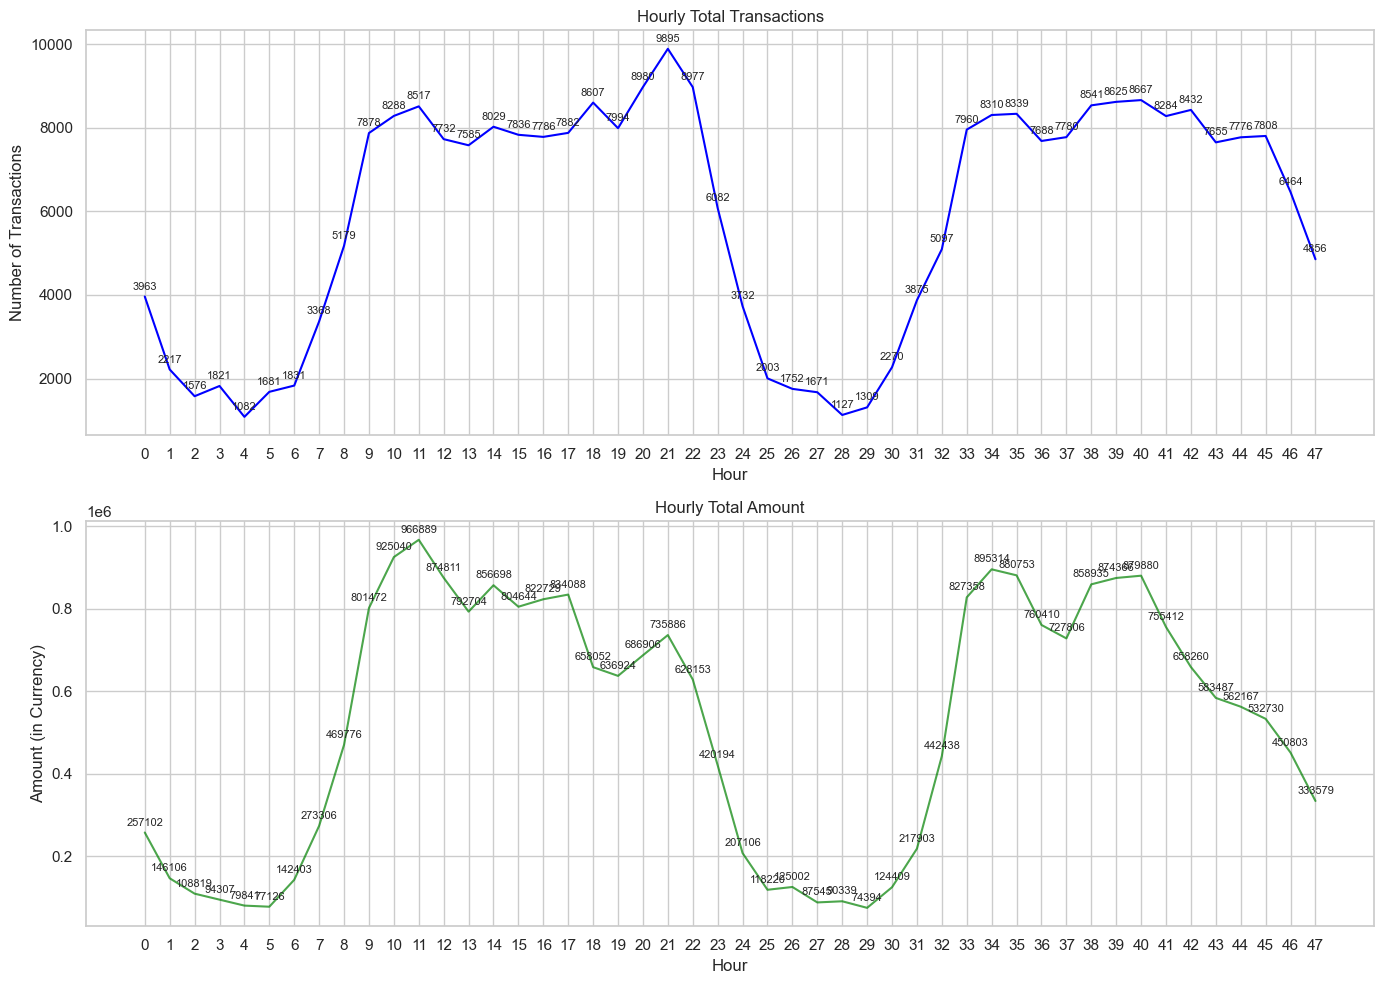

In [7]:
# Set plot style
sns.set(style='whitegrid')

# Create two subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))  # 2 rows, 1 column

# Plot Total Transactions
axes[0].plot(txn_volume['total_txns'], label='Total Transactions', color='blue')
axes[0].set_title('Hourly Total Transactions')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Number of Transactions')
axes[0].set_xticks(range(0, len(txn_volume), 1))

for i, value in enumerate(txn_volume['total_txns']):
    axes[0].annotate(f'{value:.0f}', xy=(i, value), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=8)

# Plot Total Amount
axes[1].plot(txn_volume['total_amount'], label='Total Amount', color='green', alpha=0.7)
axes[1].set_title('Hourly Total Amount')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Amount (in Currency)')
axes[1].set_xticks(range(0, len(txn_volume), 1))
# axes[1].set_yscale('log')  # <-- Set log scale here
# axes[1].set_ylim(5e4, 1.05e6)  # Optional: limit from 50k to 10 lakh

for i, value in enumerate(txn_volume['total_amount']):
    axes[1].annotate(f'{value:.0f}', xy=(i, value), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=8)


# Adjust layout
plt.tight_layout()
plt.show()


### 2. Decomposing the time series into trend, seasonality, and residuals

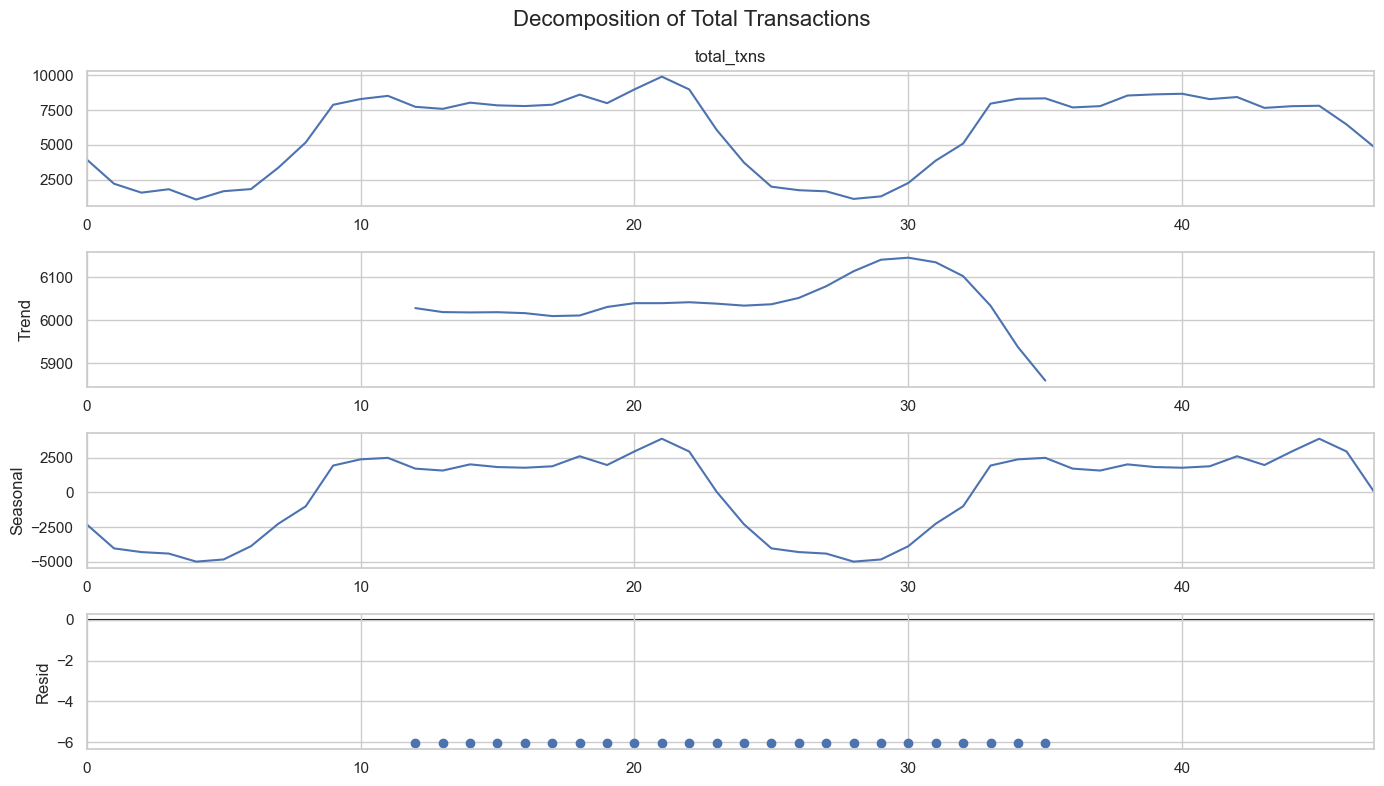

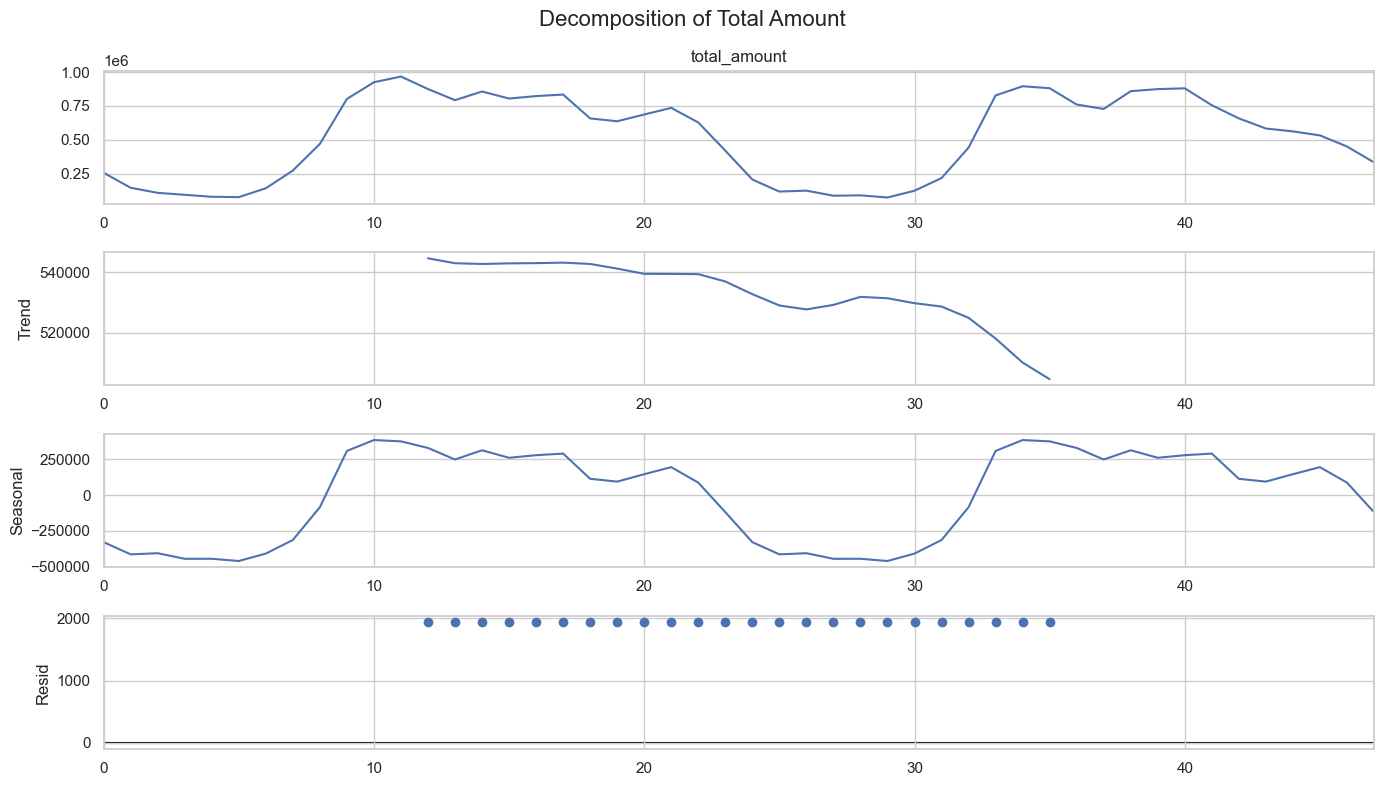

In [8]:
# Decompose time series (example with total_txns)
decomposition = seasonal_decompose(txn_volume['total_txns'], model='additive', period=24)  # assuming 24-hour periodicity
fig = decomposition.plot()                              #Plot the decomposition
fig.set_size_inches(14, 8)
fig.suptitle('Decomposition of Total Transactions', fontsize=16)
plt.tight_layout()
plt.show()


# Decompose time series (example with total_amount)
decomposition = seasonal_decompose(txn_volume['total_amount'], model='additive', period=24)  # assuming 24-hour periodicity
fig = decomposition.plot()                              #Plot the decomposition
fig.set_size_inches(14, 8)
fig.suptitle('Decomposition of Total Amount', fontsize=16)
plt.tight_layout()
plt.show()

### 3. Moving Averages to observe Smoothing

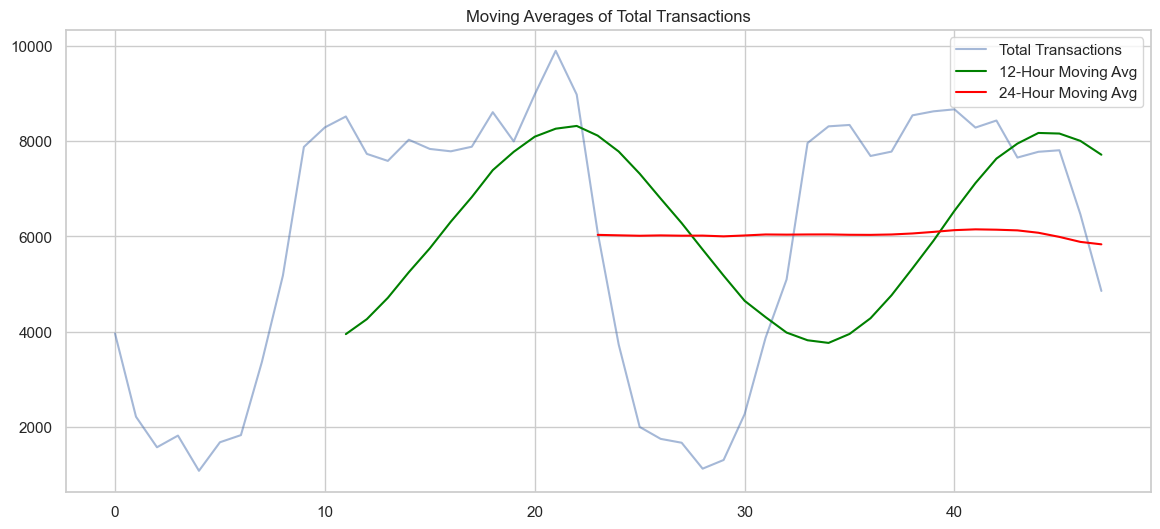

In [9]:
# Moving average (rolling mean)
txn_volume['MA_12hr'] = txn_volume['total_txns'].rolling(window=12).mean()  # 12-hour window
txn_volume['MA_24hr'] = txn_volume['total_txns'].rolling(window=24).mean()

# Plot moving averages
plt.figure(figsize=(14, 6))
plt.plot(txn_volume['total_txns'], label='Total Transactions', alpha=0.5)
plt.plot(txn_volume['MA_12hr'], label='12-Hour Moving Avg', color='green')  #half day patterns
plt.plot(txn_volume['MA_24hr'], label='24-Hour Moving Avg', color='red')    # Day to day changes
plt.title('Moving Averages of Total Transactions')
plt.legend()
plt.show()

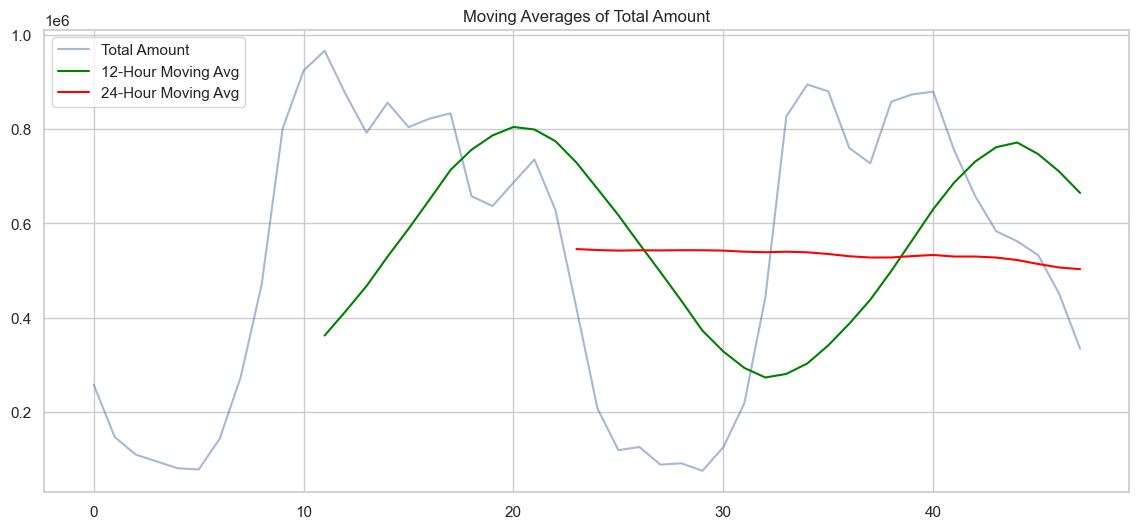

In [10]:
# Moving average (rolling mean)
txn_volume['MA_12hr'] = txn_volume['total_amount'].rolling(window=12).mean()  # 12-hour window
txn_volume['MA_24hr'] = txn_volume['total_amount'].rolling(window=24).mean()

# Plot moving averages
plt.figure(figsize=(14, 6))
plt.plot(txn_volume['total_amount'], label='Total Amount', alpha=0.5)
plt.plot(txn_volume['MA_12hr'], label='12-Hour Moving Avg', color='green')  #half day patterns
plt.plot(txn_volume['MA_24hr'], label='24-Hour Moving Avg', color='red')    # Day to day changes
plt.title('Moving Averages of Total Amount')
plt.legend()
plt.show()

### Notes :
#### Decomposition.
Decomposition of time series is not very good with 48hr of data, it needs more data.it require longer window to detect trends and patterns and will be nominated by noise if trend cant be properly established.

#### Moving Average.
Using MA instead as it smooth short-term fluctuations, helping you observe underlying trends or shifts.

# Model Building

## 1. Prophet

In [11]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


### 1. Prepare the data for Prophet:

In [12]:
from prophet import Prophet

# Feeding dataframe where ds=datetime and y= value you want to forecast.
Volume_prophet = txn_volume[['Date', 'total_txns']].rename(columns={'Date': 'ds', 'total_txns': 'y'})

### 2. Fit and forecast:

In [13]:
#model object
m = Prophet()        

#Training the model
m.fit(Volume_prophet)

#New dataframe with both hostorical timestamps and 48hr extra future period (no y values here as we are forecasting those).
future_prophet = m.make_future_dataframe(periods=48, freq='H')

#Generates forecast
forecast_prophet = m.predict(future_prophet)

09:30:08 - cmdstanpy - INFO - Chain [1] start processing
09:30:09 - cmdstanpy - INFO - Chain [1] done processing


### 3. Plot the forecast

In [14]:
from prophet.plot import plot_plotly
import plotly.offline as py

# This creates an interactive plot
fig = plot_plotly(m, forecast_prophet)

# Show the plot in notebook or browser
py.iplot(fig)  # For Jupyter Notebook



## 2. ARIMA

In [15]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima


### 1. Prepare the data

In [17]:
Volume_arima = txn_volume[['Date', 'total_txns']].copy()
Volume_arima.set_index('Date', inplace=True)


### 2. Check for stationarity (ADF Test)

In [18]:
result = adfuller(Volume_arima['total_txns'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -3.0530069719393143
p-value: 0.03023205804068368


### 3. Fit ARIMA using auto_arima (chooses p, d, q automatically)

In [19]:
stepwise_model = auto_arima(
    Volume_arima['total_txns'],
    start_p=1, start_q=1,
    max_p=3, max_q=3,
    seasonal=False,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)
print(stepwise_model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=805.470, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=982.210, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=816.709, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=800.974, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=798.986, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=800.967, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=802.483, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=792.323, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=815.358, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=793.393, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=794.017, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=803.535, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=795.316, Time=0.05 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Tota

### 4. Forecast next 48 steps (e.g., next 48 hours)


In [20]:
n_periods = 48
forecast, conf_int = stepwise_model.predict(n_periods=n_periods, return_conf_int=True)


### 5. Plot the forecast

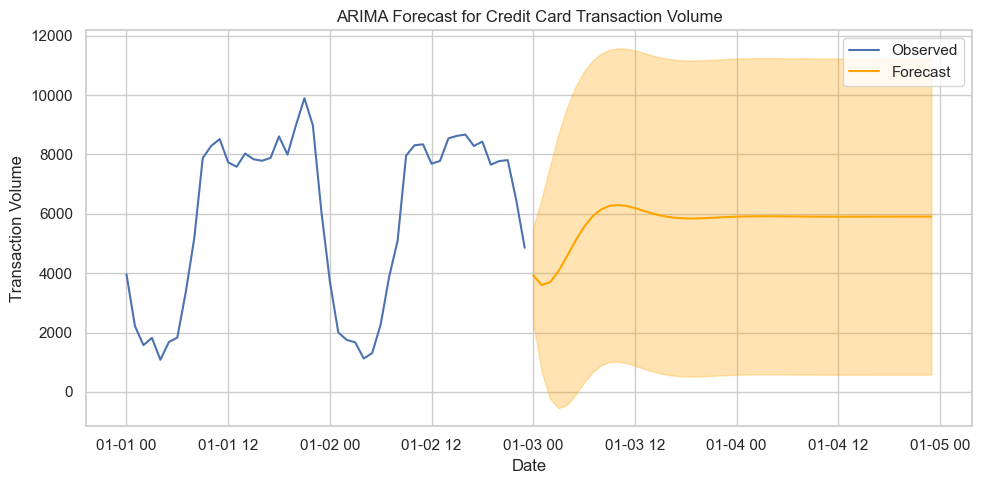

In [21]:
# Create index for future dates
last_date = Volume_arima.index[-1]
future_arima = pd.date_range(start=last_date + pd.Timedelta(hours=1), periods=n_periods, freq='H')

# Build forecast DataFrame
forecast_arima = pd.DataFrame({
    'Date': future_arima,
    'Forecast': forecast,
    'Lower CI': conf_int[:, 0],
    'Upper CI': conf_int[:, 1]
})

# Plot
plt.figure(figsize=(10, 5))
plt.plot(Volume_arima.index, Volume_arima['total_txns'], label='Observed')
plt.plot(forecast_arima['Date'], forecast_arima['Forecast'], label='Forecast', color='orange')
plt.fill_between(forecast_arima['Date'], forecast_arima['Lower CI'], forecast_arima['Upper CI'], color='orange', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Transaction Volume')
plt.title('ARIMA Forecast for Credit Card Transaction Volume')
plt.legend()
plt.tight_layout()
plt.show()


# 5. Anomaly Detection

In [35]:
# Merge actual and predicted values
merged = Volume_prophet.merge(forecast_prophet[['ds', 'yhat']], on='ds', how='left')

# Calculate residuals
merged['residual'] = merged['y'] - merged['yhat']
# print(merged)

# Calculate standard deviation of residuals
std_dev = merged['residual'].std()

# Label anomalies: 1 if residual > 2*std_dev, else 0
merged['is_anomaly'] = np.where(abs(merged['residual']) > 2 * std_dev, 1, 0)

# View anomalies
anomalies = merged[merged['is_anomaly'] == 1]


2685.748706734157


In [29]:
# # Plot
# plt.figure(figsize=(15, 6))
# plt.plot(merged['ds'], merged['y'], label='Actual', color='blue')
# plt.plot(merged['ds'], merged['yhat'], label='Forecast', color='orange')
# plt.scatter(anomalies['ds'], anomalies['y'], color='red', label='Anomaly', s=50, zorder=5)

# plt.xlabel('Date')
# plt.ylabel('Transaction Volume')
# plt.title('Actual vs Forecast with Anomalies')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [31]:
anomalies = merged[merged['is_anomaly'] == 1]


In [33]:
print(anomalies)

Empty DataFrame
Columns: [ds, y, yhat, residual, is_anomaly]
Index: []
